#**Region Based Convolutional Neural Network**


- In this project we will implement R-CNN on raccoon dataset toclassify the image as raccoon or not raccoon.


![photo](https://miro.medium.com/max/1400/0*Esmqth8McxPM2YtB.png)
- The R-CNN works as follow:
  - First Input the image.
  - Extract Regions that might have object using selective search on the input image.
  - Compute IOU between the region and the true bounding box to label the regions according to their classes.
  - Training the CNN Model on the regions with softmax in the last layer to classify them which region region belongs to which class.

### 1. Importing Libraries

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.image import non_max_suppression
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import pickle,os,cv2,random

### 2. Loading images and annotations

In [ ]:
%%capture
# Loading images
!gdown --id 1bT5CZ8nEkhLOAb518lXEyYwHqIBdOBp8
!unzip '/content/images'
# Loading annotations
!gdown --id 1FV-gC3wHfFLRxKptktvycOZbrpfGEvsA
!unzip '/content/annotations'

### 3. Defining different pathes and variables

In [ ]:
# images and annotations pathes
images_path = "/content/images"
annotations_path = "/content/annotations"
# path of positive and negative region proposals
positive_regions_path = "/content/Region Proposals/raccoon"
negative_regions_path = "/content/Region Proposals/no_raccoon"
Max_props_per_image = 2000
Max_props_per_testImage = 200
# Max number of +ve and -ve proposals of each image
MAX_POSITIVE = 30
MAX_NEGATIVE = 10

### 4. Defining a method to compute IOU

In [ ]:
def compute_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

### 5. Preparing the data for training the model

## First Preparing region proposals:

- Generating the region proposals of each image and computing the IOU for each proposal between it and the ground truth bounding box and writing that proposal in its folder whether raccoon folder (+ve class) or no_raccoon folder (-ve class) 

- If the IOU between the proposal and the Ground Truth Bounding Box is greater than 70% it is considered +ve class else if it is less than 5% so it is considered -ve one 

In [ ]:
# loop over the output positive and negative directories
for dirPath in (positive_regions_path, negative_regions_path):
	# if the output directory does not exist yet, create it
	if not os.path.exists(dirPath):
		os.makedirs(dirPath)
# list of all images
imagePaths = os.listdir(images_path)
# counters for +ve and -ve ROIs
totalPositive = 0
totalNegative = 0
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	imagePath = images_path + "/" + imagePath
	print(f"processing image {i+1}/{len(imagePaths)}...")
	# extract the image name and using it to load the xml file
	filename = imagePath.split(os.path.sep)[-1]
	filename = filename[:filename.rfind(".")]
	annotPath = os.path.sep.join([annotations_path,"{}.xml".format(filename)])
	# loading the annotation file and grabbing the true bounding boxes from it
	contents = open(annotPath).read()
	soup = BeautifulSoup(contents, "html.parser")
	ground_truth_boxes = []
	# extract width and height of the image
	w = int(soup.find("width").string)
	h = int(soup.find("height").string)
  # loop over all 'object' elements
	for o in soup.find_all("object"):
		# extract the label and bounding box coordinates
		label = o.find("name").string
		x_min = int(o.find("xmin").string)
		y_min = int(o.find("ymin").string)
		x_max = int(o.find("xmax").string)
		y_max = int(o.find("ymax").string)
		# truncate any bounding box coordinates that may fall outside the boundaries of the image
		x_min = max(0, x_min)
		y_min = max(0, y_min)
		x_max = min(w, x_max)
		y_max = min(h, y_max)
		# update our list of ground-truth bounding boxes
		ground_truth_boxes.append((x_min, y_min, x_max, y_max))
	# load the image
	image = cv2.imread(imagePath)
	# run selective search on the image to get the region proposals
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)
	ss.switchToSelectiveSearchFast()
	# region proposals
	rects = ss.process()
	proposedRects= []
	# loop over the rectangles generated by selective search
	for (x, y, w, h) in rects:
		proposedRects.append((x, y, x + w, y + h))
	# counters for positive and negative ROIs
	positive_ROIs = 0
	negative_ROIs = 0
	# loop over the maximum number of region proposals
	for proposedRect in proposedRects[:Max_props_per_image]:
		# unpack the proposed rectangle bounding box
		(propStartX, propStartY, propEndX, propEndY) = proposedRect
		# loop over the ground-truth bounding boxes
		for gtBox in ground_truth_boxes:
			# compute the intersection over union between the two boxes
			iou = compute_iou(gtBox, proposedRect)
			(gtStartX, gtStartY, gtEndX, gtEndY) = gtBox
			# initialize the ROI and output path
			roi = None
			outputPath = None
			# check to see if the IOU is greater than 70% *and* that
			# we have not hit our positive count limit
			if iou > 0.7 and positive_ROIs <= MAX_POSITIVE:
				# extract the ROI and then derive the output path to
				# the positive instance
				roi = image[propStartY:propEndY, propStartX:propEndX]
				filename = "{}.png".format(totalPositive)
				outputPath = os.path.sep.join([positive_regions_path,filename])
				# increment the positive counters
				positive_ROIs += 1
				totalPositive += 1
				# determine if the proposed bounding box falls *within*
			# the ground-truth bounding box
			fullOverlap = propStartX >= gtStartX
			fullOverlap = fullOverlap and propStartY >= gtStartY
			fullOverlap = fullOverlap and propEndX <= gtEndX
			fullOverlap = fullOverlap and propEndY <= gtEndY
			# check to see if there is not full overlap *and* the IoU
			# is less than 5% *and* we have not hit our negative
			# count limit
			if not fullOverlap and iou < 0.05 and negative_ROIs <= MAX_NEGATIVE:
				# extract the ROI and then derive the output path to
				# the negative instance
				roi = image[propStartY:propEndY, propStartX:propEndX]
				filename = "{}.png".format(totalNegative)
				outputPath = os.path.sep.join([negative_regions_path,filename])
				# increment the negative counters
				negative_ROIs += 1
				totalNegative += 1
			# check to see if both the ROI and output path are valid
			if roi is not None and outputPath is not None:
				# resize the ROI to the input dimensions of the CNN that we'll be fine-tuning
				roi = cv2.resize(roi,(224,224),interpolation=cv2.INTER_CUBIC)
				cv2.imwrite(outputPath, roi)

processing image 1/200...
processing image 2/200...
processing image 3/200...
processing image 4/200...
processing image 5/200...
processing image 6/200...
processing image 7/200...
processing image 8/200...
processing image 9/200...
processing image 10/200...
processing image 11/200...
processing image 12/200...
processing image 13/200...
processing image 14/200...
processing image 15/200...
processing image 16/200...
processing image 17/200...
processing image 18/200...
processing image 19/200...
processing image 20/200...
processing image 21/200...
processing image 22/200...
processing image 23/200...
processing image 24/200...
processing image 25/200...
processing image 26/200...
processing image 27/200...
processing image 28/200...
processing image 29/200...
processing image 30/200...
processing image 31/200...
processing image 32/200...
processing image 33/200...
processing image 34/200...
processing image 35/200...
processing image 36/200...
processing image 37/200...
processing

In [ ]:
# putting all the ROIs in the data list and their labels
Regions_path = "/content/Region Proposals"
Classes = os.listdir(Regions_path)
# from imutils import paths
# imagePaths = list(paths.list_images("/content/Region Proposals"))

data = []
labels = []
# loop over the image paths
for class_ in Classes:
# extract the class label from the filename
  label = class_
  label_path = Regions_path + "/" + label
  imagePath = os.listdir(label_path)
  for image_path in imagePath:
  # load the input image (224x224) and preprocess it
    image_path = label_path + "/" + image_path
    image = load_img(image_path, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
  # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
#shuffling the data
shuffler = np.random.permutation(len(labels))
data = data[shuffler]
labels = labels[shuffler]
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
# splitting the data into training and testing splits using 80% of the data for training
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

### 6. Defining the model

- Here we will use MobileNetV2 by removing its last layer and freezing all its layers and putting some Fully Connected layers on top of it for training for the data for our task. 

In [ ]:
%%capture
# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be trained
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
# freezing the layers of the MobileNetV2 model
for layer in baseModel.layers:
	layer.trainable = False

learning_rate = 1e-4
epochs = 5
batch_size = 32

# compile the model
opt = Adam(learning_rate=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])	

In [ ]:
# train the  model
history = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),steps_per_epoch=len(trainX) // batch_size,
              validation_data=(testX, testY),validation_steps=len(testX) // batch_size,epochs=epochs)

Epoch 1/5
93/93 [==============================] - 47s 357ms/step - loss: 0.2077 - accuracy: 0.9536 - val_loss: 0.0421 - val_accuracy: 0.9973
Epoch 2/5
93/93 [==============================] - 31s 335ms/step - loss: 0.0456 - accuracy: 0.9936 - val_loss: 0.0196 - val_accuracy: 0.9973
Epoch 3/5
93/93 [==============================] - 31s 332ms/step - loss: 0.0226 - accuracy: 0.9966 - val_loss: 0.0162 - val_accuracy: 0.9973
Epoch 4/5
93/93 [==============================] - 31s 335ms/step - loss: 0.0228 - accuracy: 0.9950 - val_loss: 0.0112 - val_accuracy: 0.9973
Epoch 5/5
93/93 [==============================] - 31s 336ms/step - loss: 0.0153 - accuracy: 0.9973 - val_loss: 0.0126 - val_accuracy: 0.9973


In [ ]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=batch_size)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

  no_raccoon       1.00      1.00      1.00       440
     raccoon       0.99      1.00      1.00       312

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



In [ ]:
# saving hte model
model_path = "/content/raccoon_detector.h5"
model.save(model_path, save_format="h5")

### 7. Evaluating the model

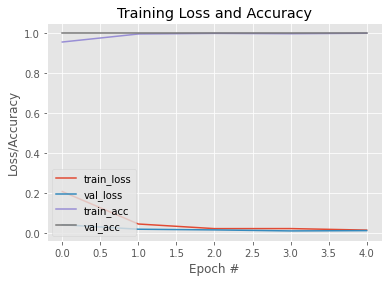

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("Plot.png")

### 8. Testing the model on input image

In [ ]:
image_name = random.choice(os.listdir(images_path))
image = cv2.imread("/content/images/"+ image_name)
(H,W) = image.shape[:2]
# resizing the image by keeping the same ratio between width and height
height = 300
width = int(height*W/H)
image = cv2.resize(image,(width,height))
# run selective search on the image to generate bounding box proposal regions
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

In [ ]:
# initialize the lists of regions proposals and coordinates of the bounding boxes
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by running selective search
for (x, y, w, h) in rects[:Max_props_per_testImage]:
	roi = image[y:y + h, x:x + w]
	# convert it from BGR to RGB channel ordering
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
  # resize it to the required input
	roi = cv2.resize(roi,(224,224),interpolation=cv2.INTER_CUBIC)
	# processing the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)
	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

In [ ]:
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
# classify each of the proposal ROIs using fine-tuned model
proba = model.predict(proposals)

In [ ]:
# find the index of all predictions that are positive for the "raccoon" class
labels = lb.classes_[np.argmax(proba, axis=1)]
idxs = np.where(labels == "raccoon")[0]
# use the indexes to extract all bounding boxes and associated class label probabilities associated with the "raccoon" class
boxes = boxes[idxs]
proba = proba[idxs][:, 1]
# choosing the regions with probability equals or over 0.99 
idxs = np.where(proba >= 0.99)
boxes = boxes[idxs]
proba = proba[idxs]

Before Non Max Supression


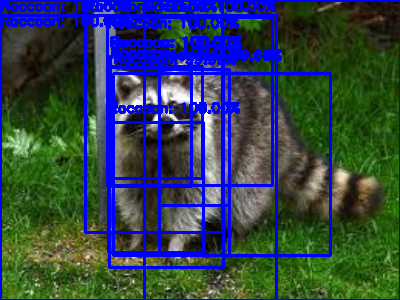

In [ ]:
copy_image = image.copy()
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	cv2.rectangle(copy_image, (startX, startY), (endX, endY),(255,0, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Raccoon: {:.2f}%".format(prob * 100)
	cv2.putText(copy_image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)
# show the output before running NMS
print("Before Non Max Supression")
cv2_imshow(copy_image)

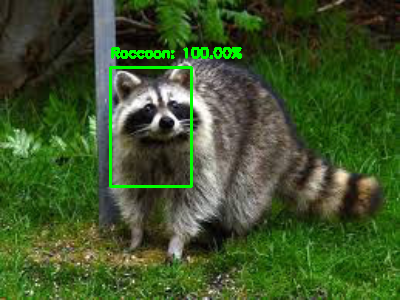

-1

In [ ]:
# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes, proba,1)
# loop over the bounding box indexes
for i in boxIdxs:
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = boxes[i.numpy()]
	cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Raccoon: {:.2f}%".format(proba[i.numpy()] * 100)
	cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
cv2_imshow(image)
cv2.waitKey(0)